BigMac Index

Dataset: BigMacPrice --> https://www.kaggle.com/datasets/vittoriogiatti/bigmacprice?resource=download

PPI: https://data.oecd.org/price/producer-price-indices-ppi.htm#indicator-chart

Forex: https://pypi.org/project/forex-python/

Questions:
- Can we predict (some price indicator)
- How did the price develop
- Does it grow at the same pace
- Does the exchange rate reflect the price difference

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
from forex_python.converter import CurrencyRates
c = CurrencyRates()

%matplotlib inline

df_bigmac = pd.read_csv('BigMacPrice.csv')
df_ppi = pd.read_csv('DP_LIVE_23112022084950389.csv')

df_bigmac.head()

date currency_code       name  local_price  dollar_ex  dollar_price
0  2000-04-01           ARS  Argentina         2.50          1          2.50
1  2000-04-01           AUD  Australia         2.59          1          2.59
2  2000-04-01           BRL     Brazil         2.95          1          2.95
3  2000-04-01           GBP    Britain         1.90          1          1.90
4  2000-04-01           CAD     Canada         2.85          1          2.85

In [9]:
df_ppi.head()

LOCATION INDICATOR   SUBJECT MEASURE FREQUENCY  TIME     Value  Flag Codes
0      AUT       PPI  DOMESTIC  AGRWTH         A  2000  3.405336         NaN
1      AUT       PPI  DOMESTIC  AGRWTH         A  2001  0.048577         NaN
2      AUT       PPI  DOMESTIC  AGRWTH         A  2002 -1.408040         NaN
3      AUT       PPI  DOMESTIC  AGRWTH         A  2003  0.285630         NaN
4      AUT       PPI  DOMESTIC  AGRWTH         A  2004  2.219603         NaN

In [14]:
def map_country(country_str):
        try:
            return pycountry.countries.lookup(country_str).name
        except LookupError:
            return None
        except Exception as e:
            print(e)
            raise ValueError

def map_exchange_usd(currency_code, date, org_currency, currency_rates):
    try:
        return round(currency_rates.get_rate(currency_code, 'USD', date), 2)
    except Exception:
        return org_currency

            
def clean_ppi(df_ppi, measure):
    # Filter PPI
    f1 = df_ppi.TIME.str.contains("-")
    f2 = df_ppi.TIME.str.contains('Q')
    f3 = df_ppi.SUBJECT == "DOMESTIC"
    f4 = df_ppi.MEASURE == measure
    mask = f1 & ~f2 &  f3 & f4

    df_ppi = df_ppi[mask]

    df_ppi['TIME'] = pd.to_datetime(df_ppi['TIME'])

    df_ppi['country'] = df_ppi['LOCATION'].apply(map_country)
    df_ppi = df_ppi[~df_ppi['country'].isnull()]
    return df_ppi


def clean_df_bigmac(df_bigmac, currency_rates):
    # Use same mapping as for df_ppi
    df_bigmac['country'] = df_bigmac.name.apply(map_country)
    # Few countries unable to map in pycountry - so do manually
    remap = {'Britain': 'United Kingdom',
             'Russia': 'Russian Federation',
             'UAE': 'United Arab Emirates'}
    df_bigmac['country'] = df_bigmac['name'].replace(remap)
    
    # Seems to be an error in consistency of the date column for the given dates
    df_bigmac.loc[df_bigmac.date == "2019-07-09", "date"] = "2019-07-01"
    df_bigmac.loc[df_bigmac.date == "2020-01-14", "date"] = "2020-01-01"
    
    # Set col date col to datetime for joining purposes
    df_bigmac['date'] = pd.to_datetime(df_bigmac['date'])
    
    # Map Exchange Rates
    df_bigmac['dollar_ex_adjusted'] = df_bigmac.apply(lambda x: map_exchange_usd(currency_code=x.currency_code,
                                                                                   date=x.date,
                                                                                   org_currency=x.dollar_price,
                                                                                   currency_rates=currency_rates),
                                                         axis=1)
    
    return df_bigmac

In [15]:
# Clean Data Frames
df_ppi_cleaned = clean_ppi(df_ppi, "IDX2015")
df_bigmac_cleaned = clean_df_bigmac(df_bigmac=df_bigmac, currency_rates=c)

C:\Users\C77561\AppData\Local\Temp\ipykernel_29580\636517587.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppi['TIME'] = pd.to_datetime(df_ppi['TIME'])
C:\Users\C77561\AppData\Local\Temp\ipykernel_29580\636517587.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppi['country'] = df_ppi['LOCATION'].apply(map_country)


In [16]:
# Put together in 1 DataFrame, and put all rows in perspective to the US ($)
df = pd.merge(df_bigmac, df_ppi_cleaned, left_on=['date', 'country'], right_on=['TIME', 'country'], how='left')
df = df.set_index('date')

# Create a seperate dataframe with only USA prices, to join
df_comparison = df[df['country'] == "United States"]
df = df.join(df_comparison[['local_price']], how='left', rsuffix="_comparison")

# Set expected prices and difference based on exchange rates in local currency
df['expected_price'] = df['local_price_comparison'] * df['dollar_ex_adjusted']
df['diff_local'] = df['local_price'] - df['expected_price']

# Set expected prices and difference based on exchange rates in local currency
df['dollar_price_adjusted'] = df['local_price'] * df['dollar_ex_adjusted']
df['diff_dollar'] = df['dollar_price_adjusted'] - df['local_price_comparison']

df.head()

currency_code       name  local_price  dollar_ex  dollar_price  \
date                                                                        
2000-04-01           ARS  Argentina         2.50          1          2.50   
2000-04-01           AUD  Australia         2.59          1          2.59   
2000-04-01           BRL     Brazil         2.95          1          2.95   
2000-04-01           GBP    Britain         1.90          1          1.90   
2000-04-01           CAD     Canada         2.85          1          2.85   

                   country  dollar_ex_adjusted LOCATION INDICATOR   SUBJECT  \
date                                                                          
2000-04-01       Argentina                2.50      NaN       NaN       NaN   
2000-04-01       Australia                0.60      NaN       NaN       NaN   
2000-04-01          Brazil                2.95      NaN       NaN       NaN   
2000-04-01  United Kingdom                1.60      GBR       PPI  DOMESTIC   
2000-04-01          Canada                0.69      NaN       NaN       NaN   

            MEASURE FREQUENCY       TIME    Value  Flag Codes  \
date                                                            
2000-04-01      NaN       NaN        NaT      NaN         NaN   
2000-04-01      NaN       NaN        NaT      NaN         NaN   
2000-04-01      NaN       NaN        NaT      NaN         NaN   
2000-04-01  IDX2015         M 2000-04-01  73.8346         NaN   
2000-04-01      NaN       NaN        NaT      NaN         NaN   

            local_price_comparison  expected_price  diff_local  \
date                                                             
2000-04-01                    2.24          5.6000     -3.1000   
2000-04-01                    2.24          1.3440      1.2460   
2000-04-01                    2.24          6.6080     -3.6580   
2000-04-01                    2.24          3.5840     -1.6840   
2000-04-01                    2.24          1.5456      1.3044   

            dollar_price_adjusted  diff_dollar  
date                                            
2000-04-01                 6.2500       4.0100  
2000-04-01                 1.5540      -0.6860  
2000-04-01                 8.7025       6.4625  
2000-04-01                 3.0400       0.8000  
2000-04-01                 1.9665      -0.2735

In [ ]:
# Pickle Dataset, because the creation takes too long
df.to_pickle('')

In [6]:
# Check if PPI data for all countries and currencies

only_nulls = []
full_period = []
semi_period = []

for c in df.country.unique():
    total = len(df[df.country == c])
    nulls = np.sum(df[df.country == c].LOCATION.isnull())
    if total == nulls:
        only_nulls += [c]
    elif nulls == 0:
        full_period += [c]
    else:
        semi_period += [c]
        
print(f"No PPI Data: {len(only_nulls)}")
print(f"PPI Data full period: {len(full_period)}")
print(f"Partly PPI data: {len(semi_period)}")         

No PPI Data: 42
PPI Data full period: 30
Partly PPI data: 1


In [7]:
import seaborn as sns

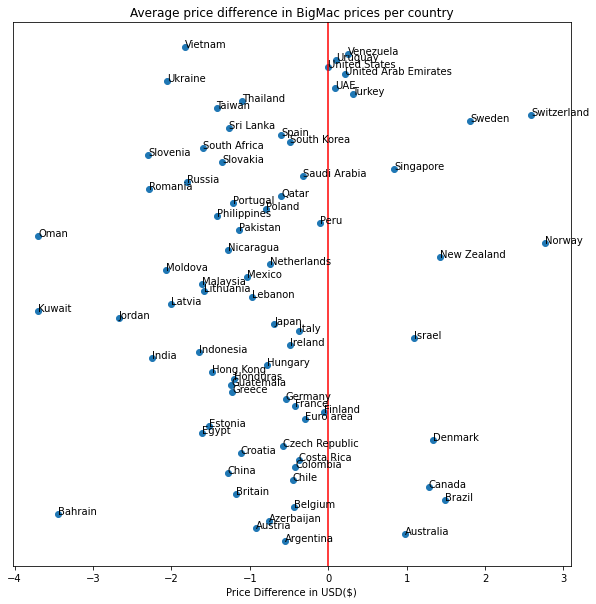

In [8]:
# Check which countries are on average over/undervalued based on the BigMacPrice
df_grouped = df[['diff_dollar', 'name']].groupby('name').aggregate([np.mean])
x=df_grouped[('diff_dollar', 'mean')]
y=df_grouped.index

fig, ax = plt.subplots(figsize=(10,10))
plt.axvline(x=0, color='r', label='Expected price difference')
plt.xlabel('Price Difference in USD($)')
plt.title('Average price difference in BigMac prices per country')
ax.set_yticks([])
ax.scatter(x, y)

for i, txt in enumerate(df_grouped.index):
    ax.annotate(txt, (x[i], y[i]))

In [20]:
df.head()

currency_code       name  local_price  dollar_ex  dollar_price  \
date                                                                        
2000-04-01           ARS  Argentina         2.50          1          2.50   
2000-04-01           AUD  Australia         2.59          1          2.59   
2000-04-01           BRL     Brazil         2.95          1          2.95   
2000-04-01           GBP    Britain         1.90          1          1.90   
2000-04-01           CAD     Canada         2.85          1          2.85   

                   country LOCATION INDICATOR   SUBJECT  MEASURE FREQUENCY  \
date                                                                         
2000-04-01       Argentina      NaN       NaN       NaN      NaN       NaN   
2000-04-01       Australia      NaN       NaN       NaN      NaN       NaN   
2000-04-01          Brazil      NaN       NaN       NaN      NaN       NaN   
2000-04-01  United Kingdom      GBR       PPI  DOMESTIC  IDX2015         M   
2000-04-01          Canada      NaN       NaN       NaN      NaN       NaN   

                 TIME    Value  Flag Codes  local_price_comparison  \
date                                                                 
2000-04-01        NaT      NaN         NaN                    2.24   
2000-04-01        NaT      NaN         NaN                    2.24   
2000-04-01        NaT      NaN         NaN                    2.24   
2000-04-01 2000-04-01  73.8346         NaN                    2.24   
2000-04-01        NaT      NaN         NaN                    2.24   

            expected_price  diff_local  diff_dollar  
date                                                 
2000-04-01            2.24        0.26         0.26  
2000-04-01            2.24        0.35         0.35  
2000-04-01            2.24        0.71         0.71  
2000-04-01            2.24       -0.34        -0.34  
2000-04-01            2.24        0.61         0.61

In [54]:
import plotly.express as px
test = df.reset_index()
test['date_s'] = test['date'].astype(str)

fig = px.scatter(test, x="diff_dollar", y="country", animation_frame="date_s",
        color="country", hover_name="country", range_x=[-6, 6], animation_group='country')
fig.show()

C:\Users\C77561\AppData\Local\Temp\ipykernel_24376\794015652.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches


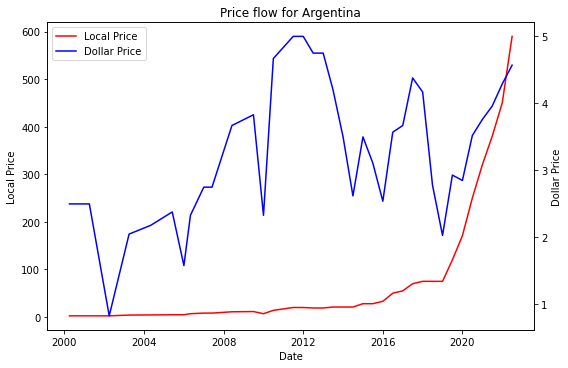

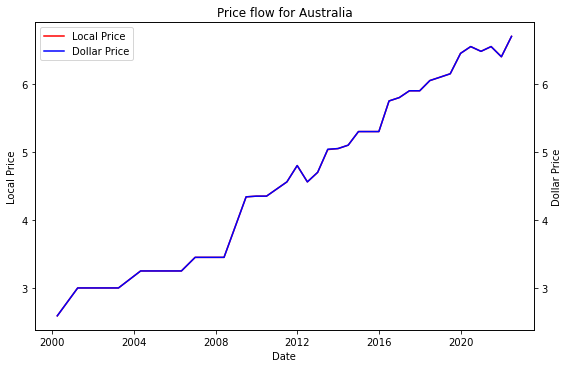

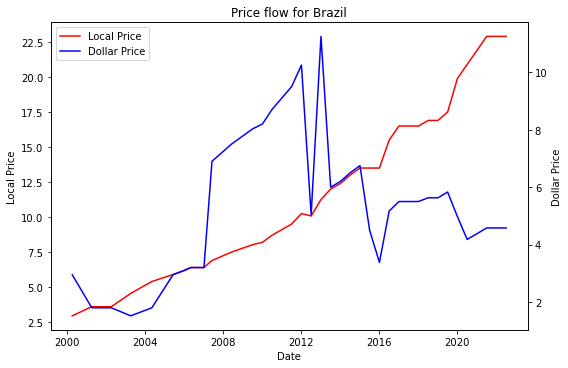

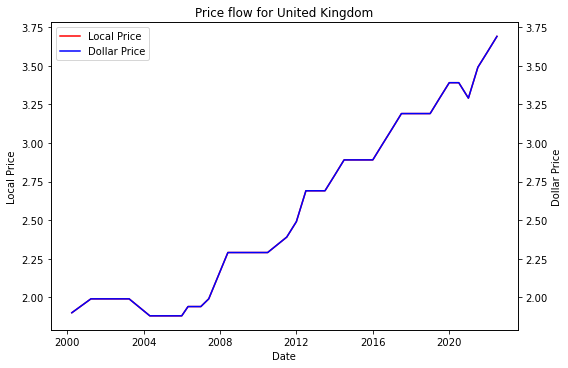

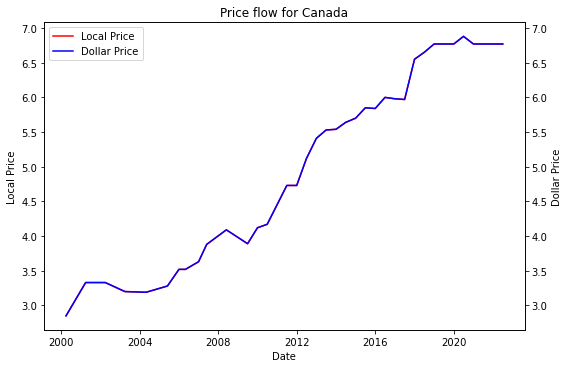

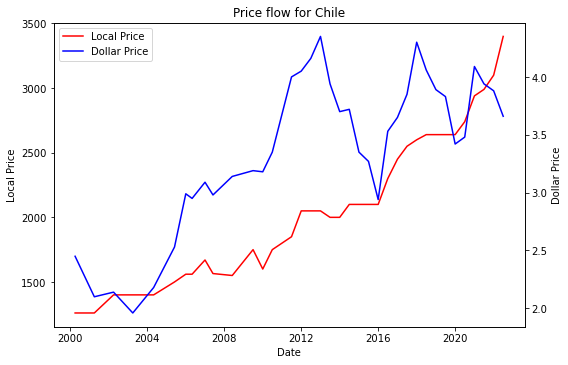

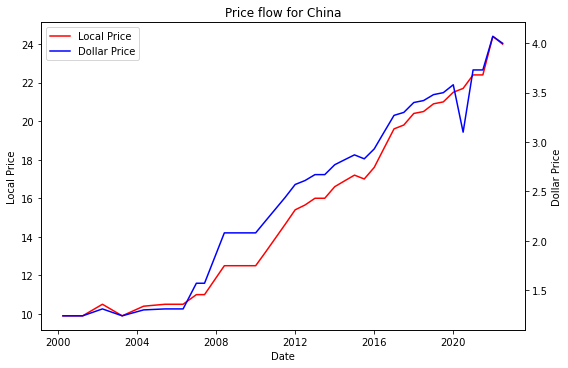

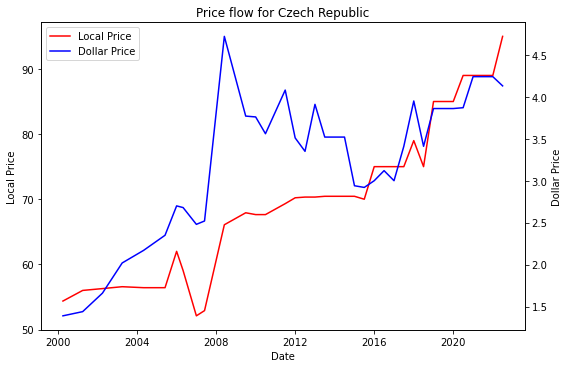

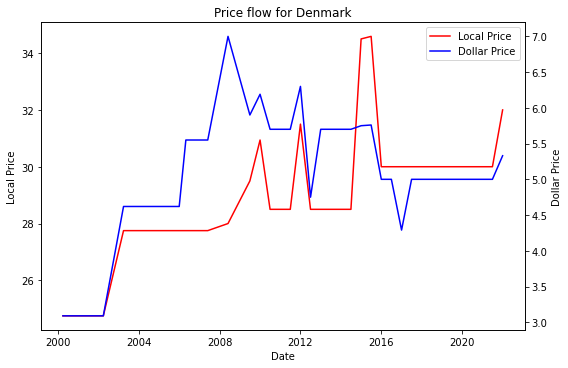

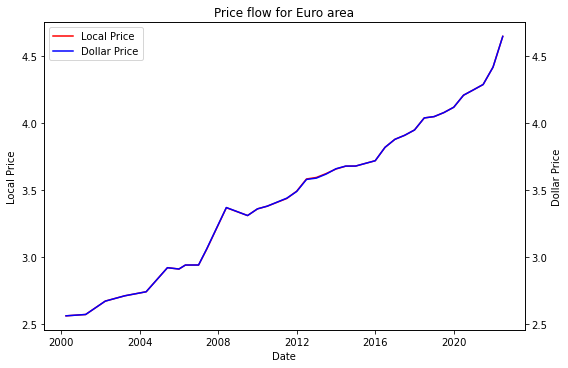

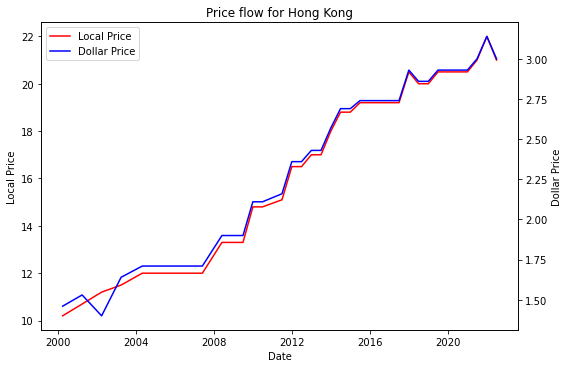

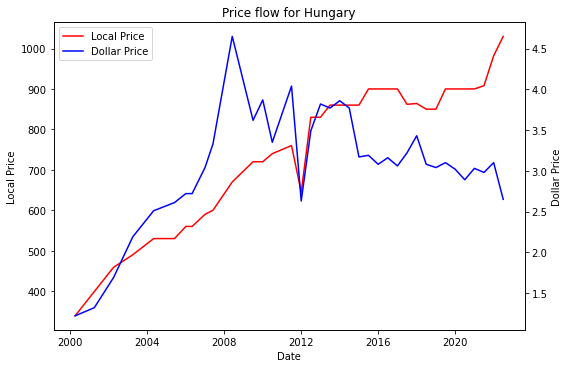

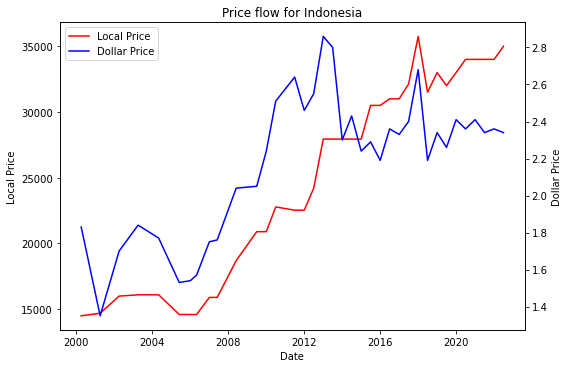

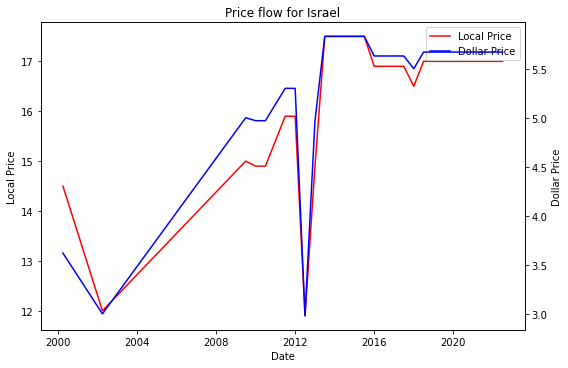

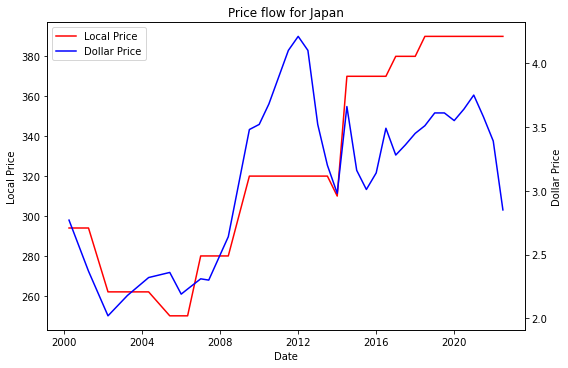

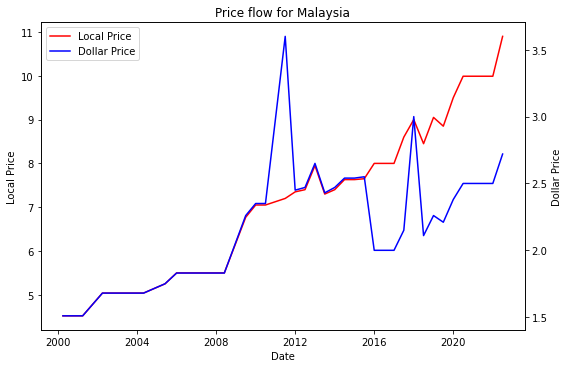

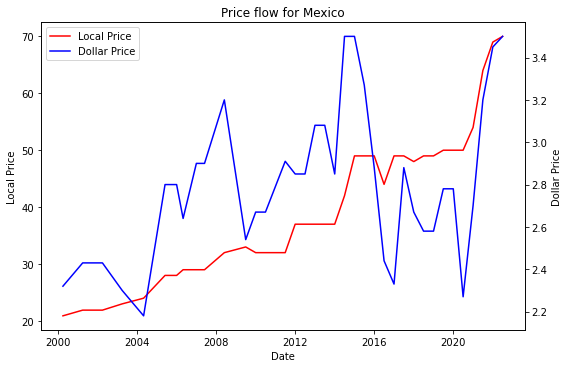

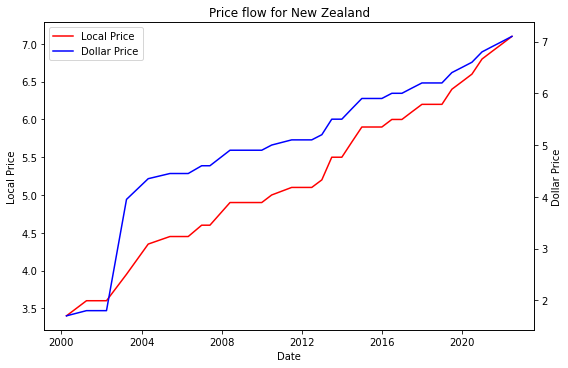

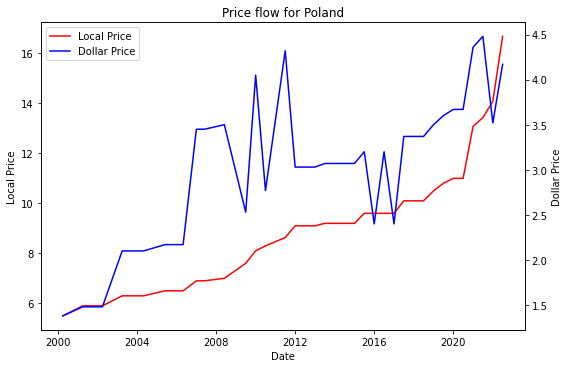

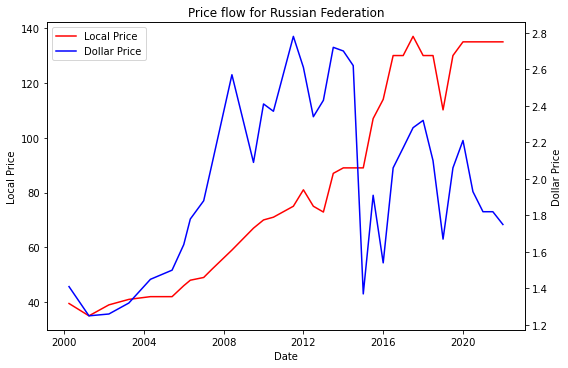

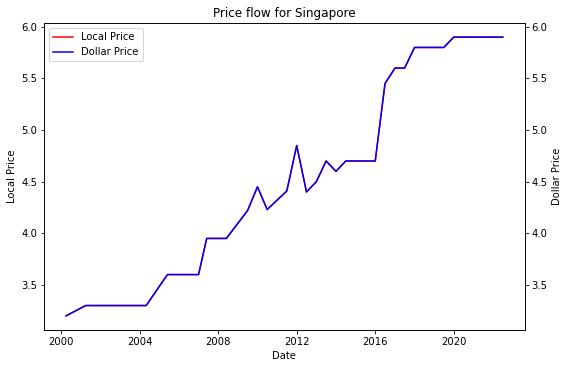

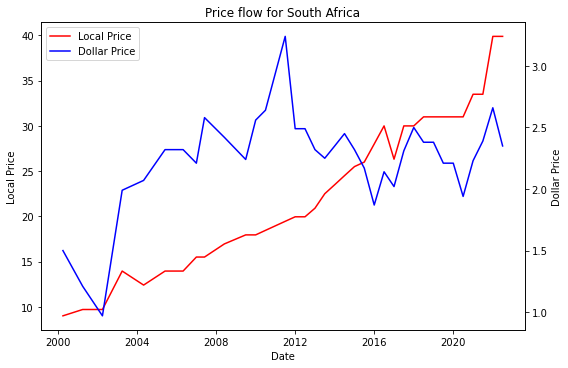

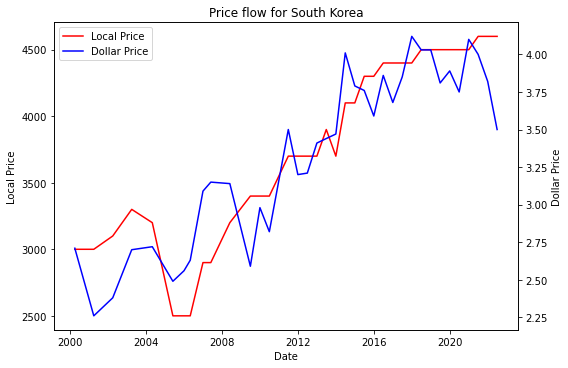

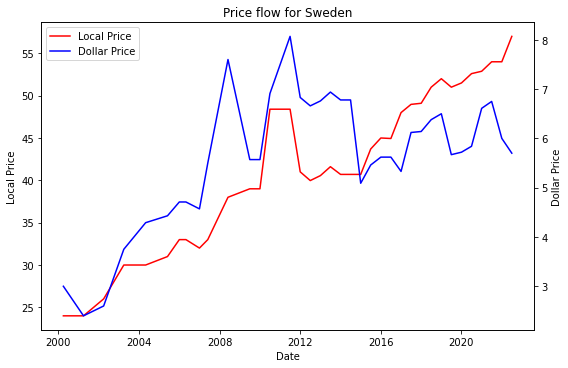

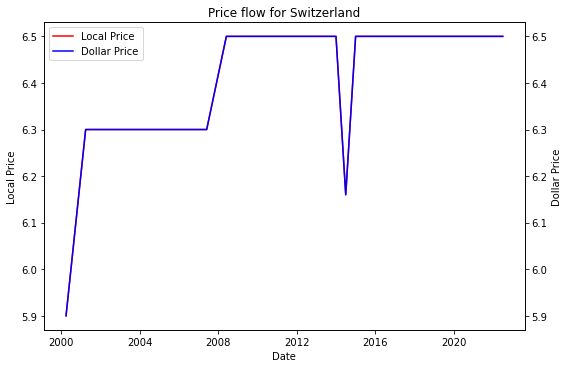

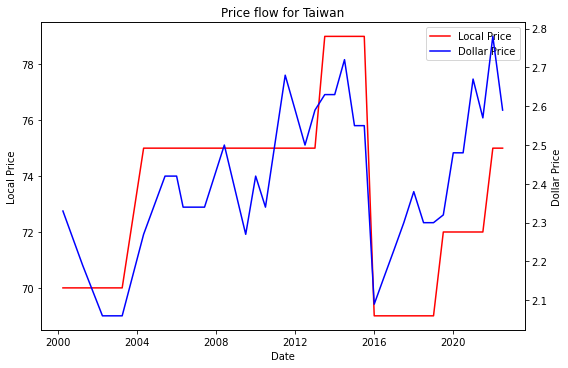

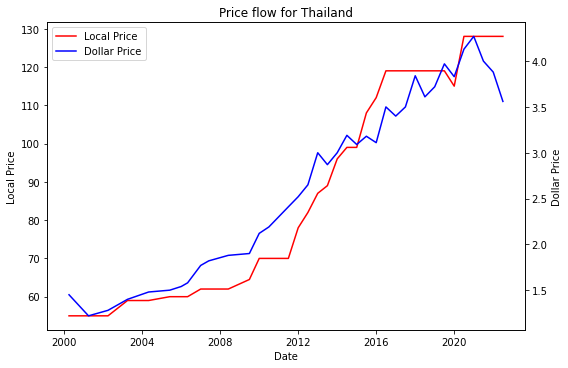

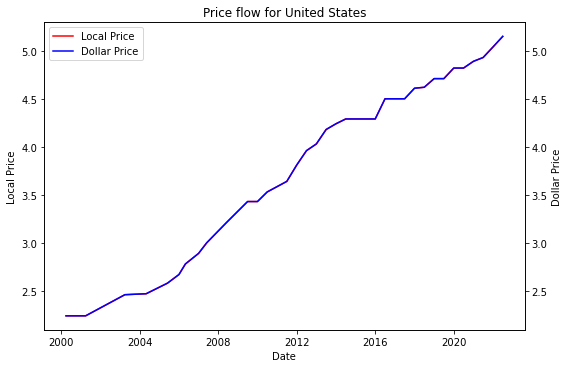

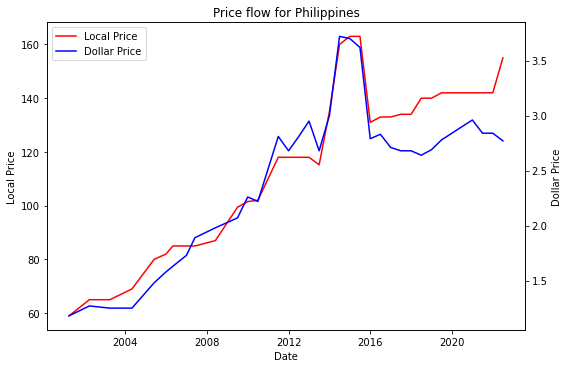

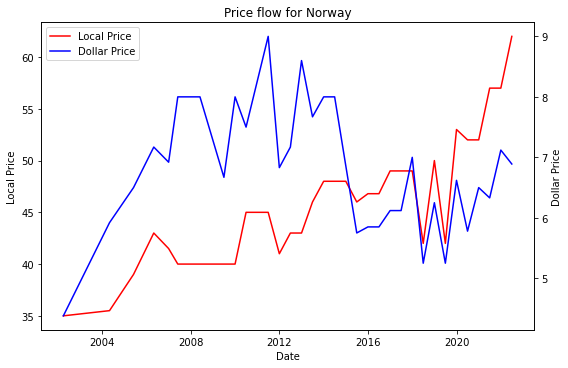

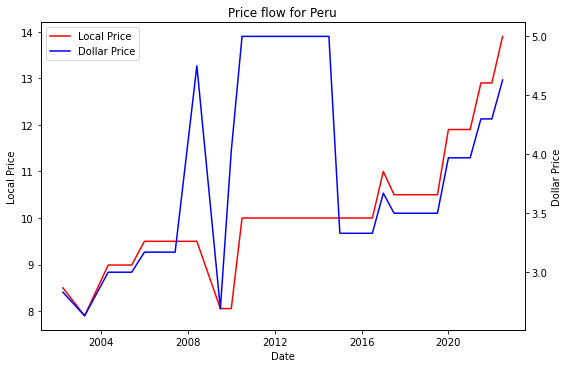

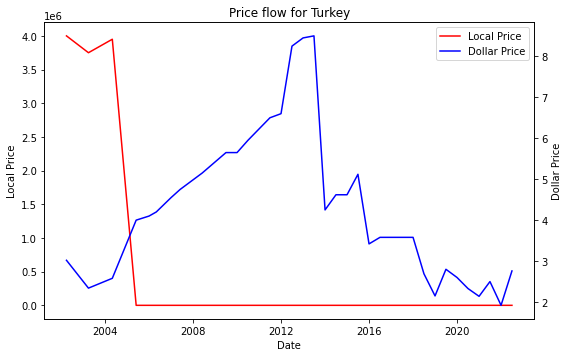

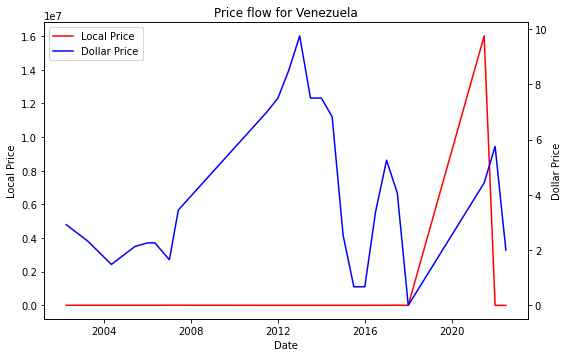

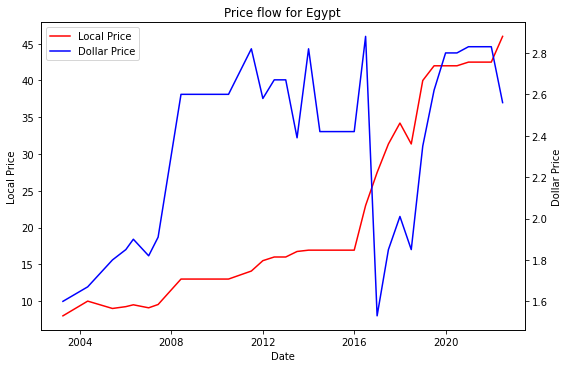

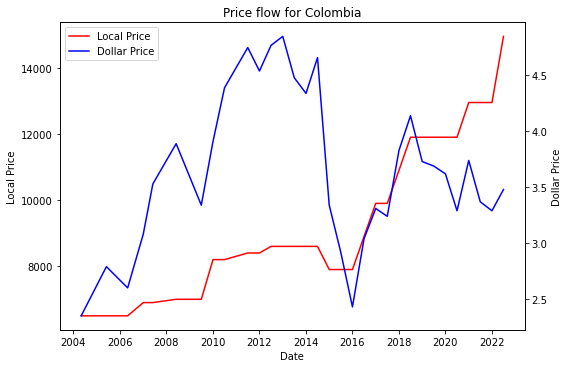

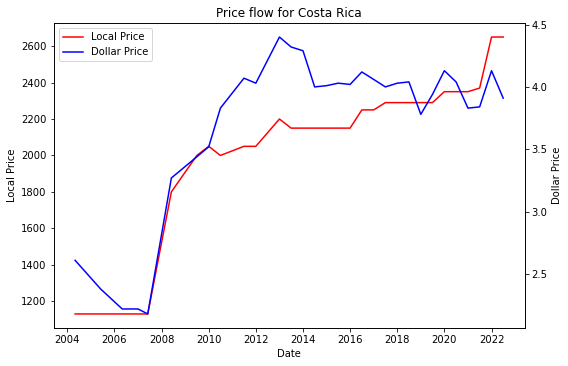

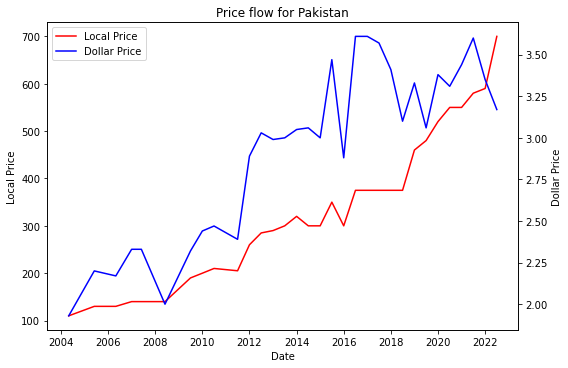

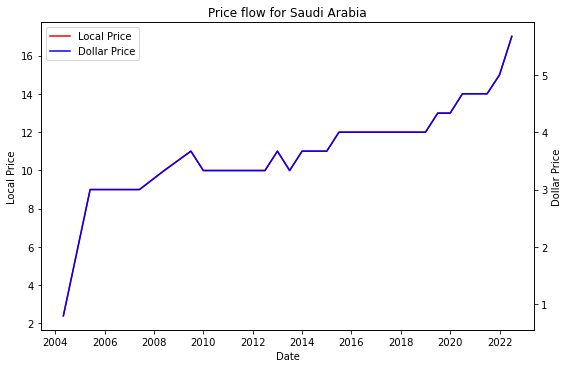

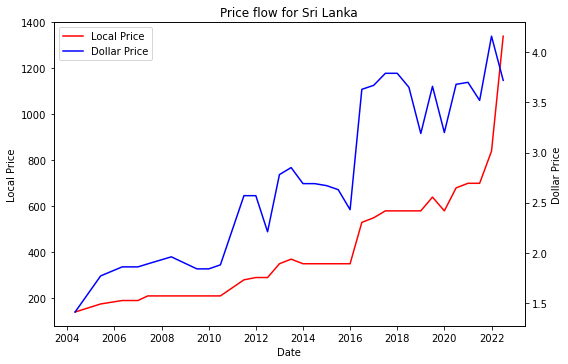

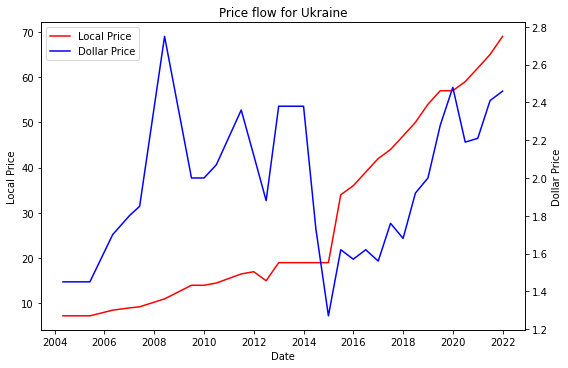

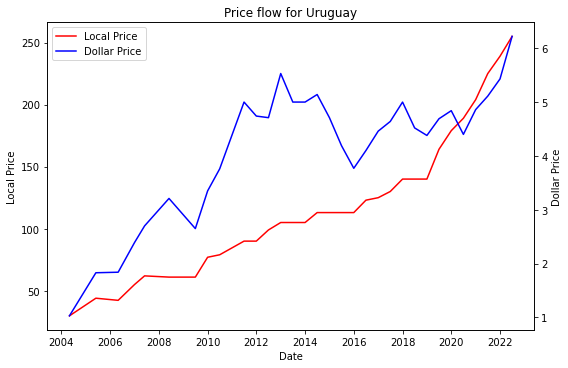

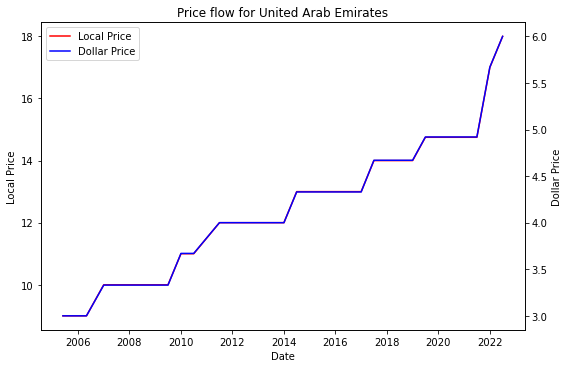

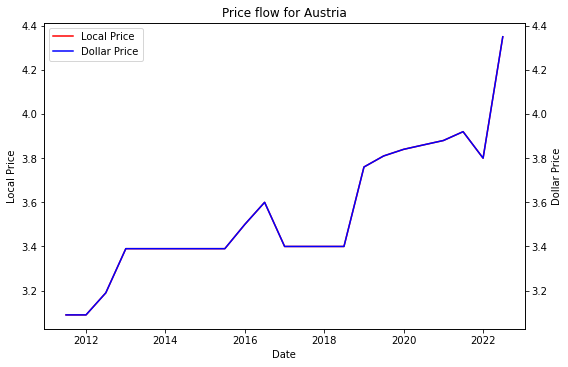

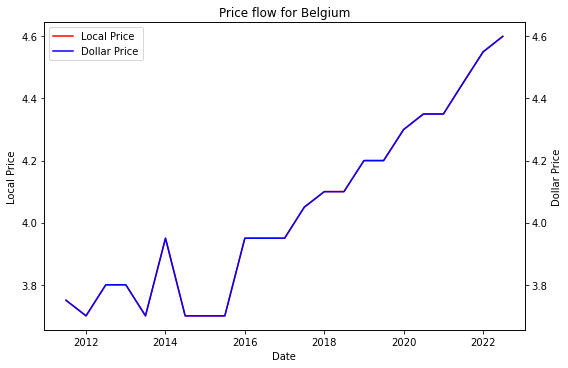

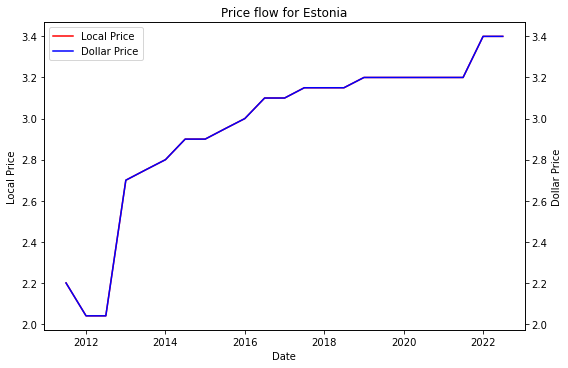

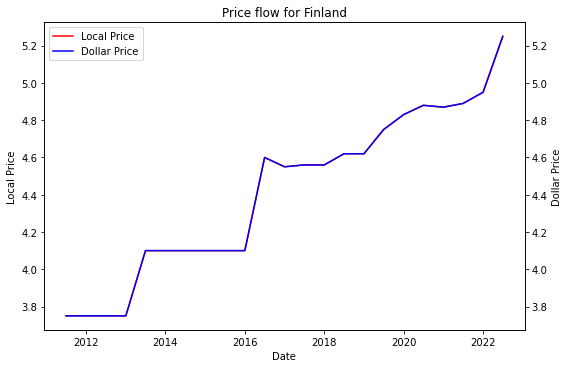

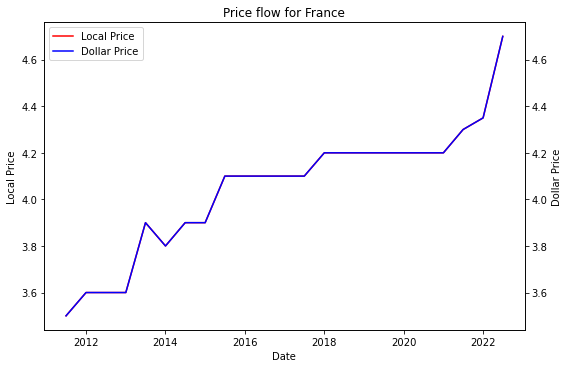

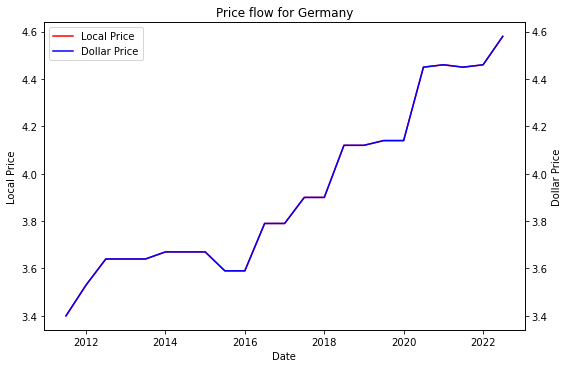

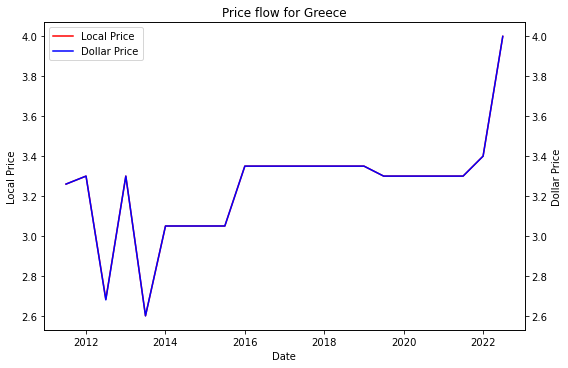

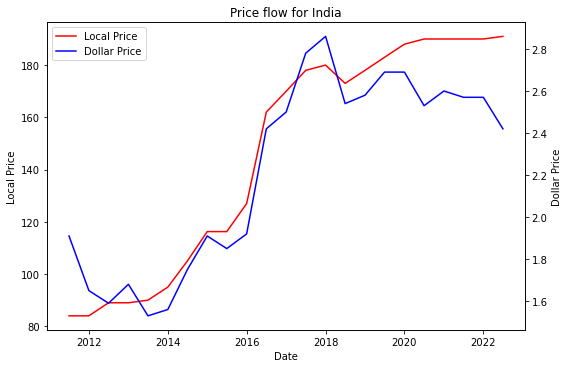

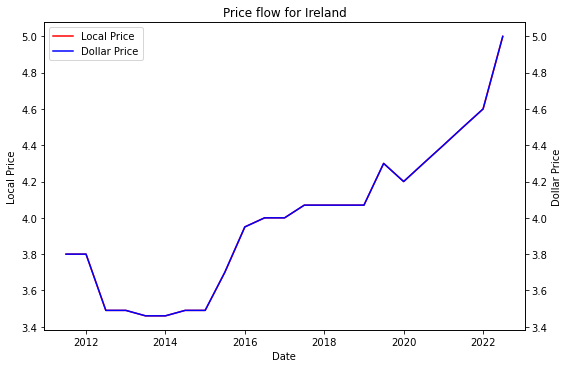

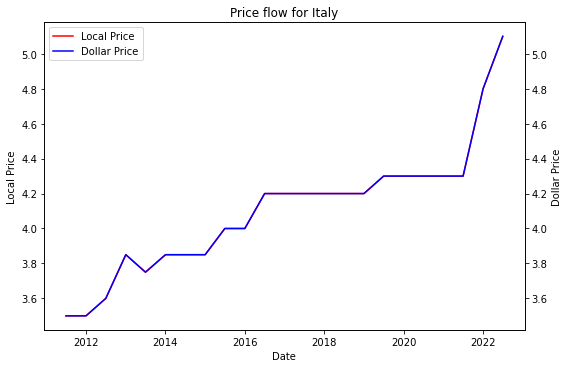

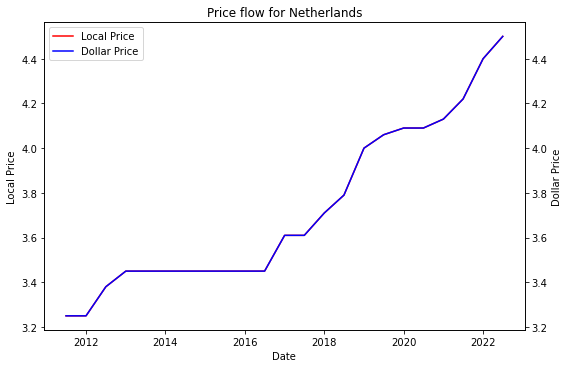

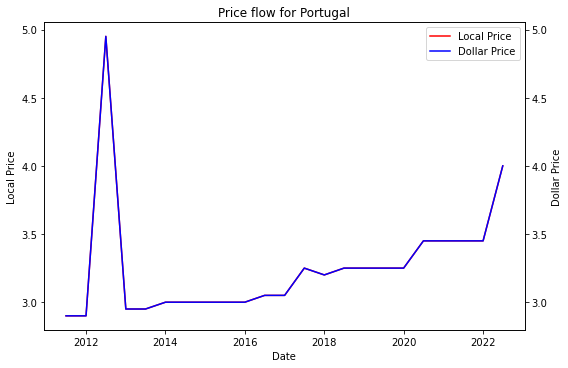

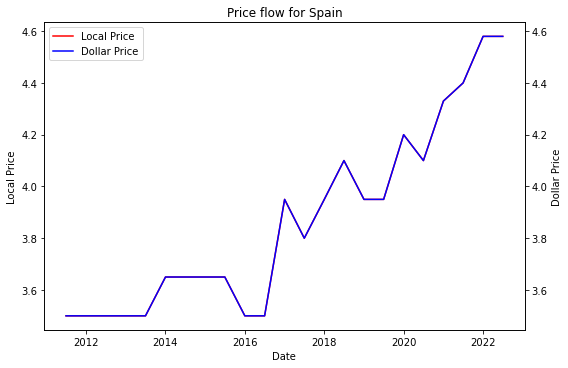

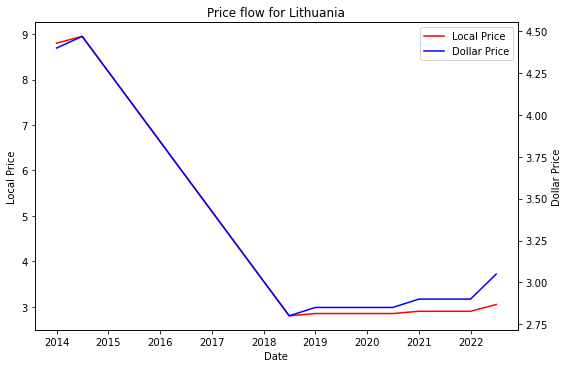

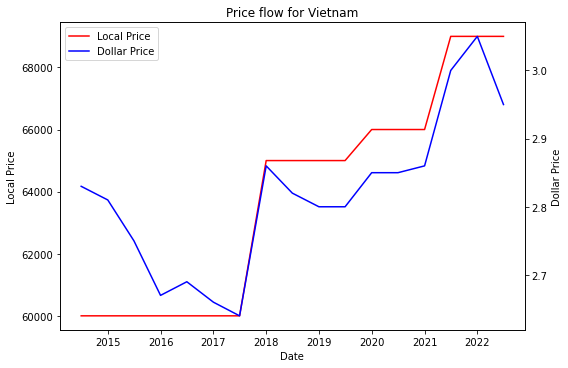

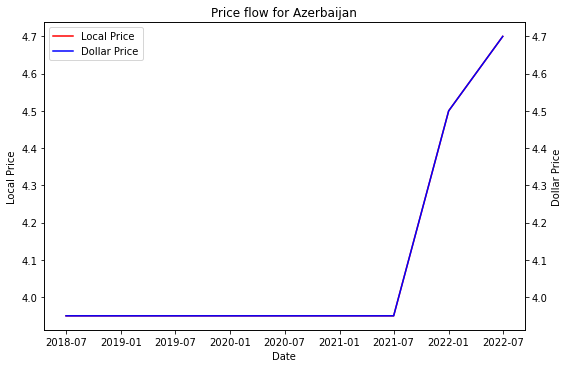

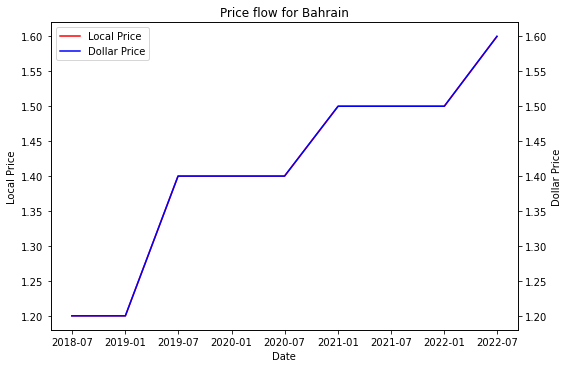

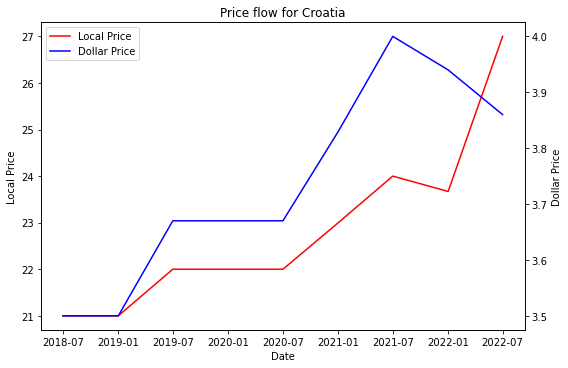

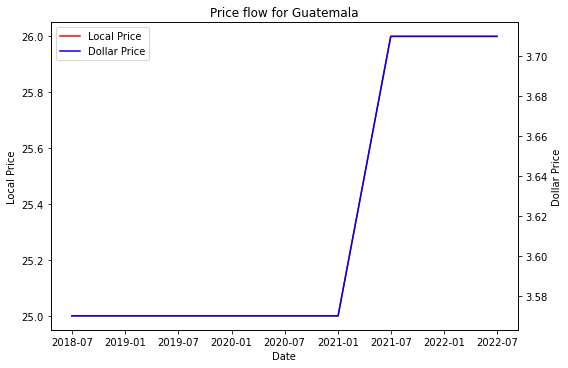

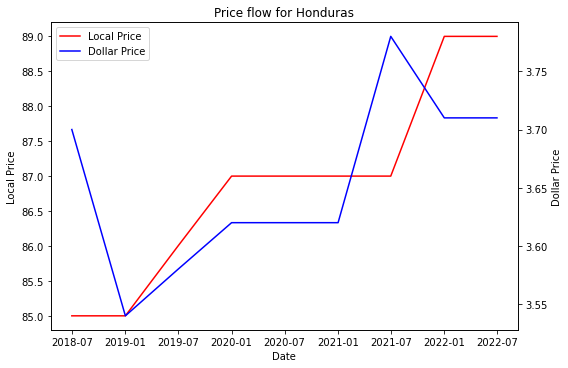

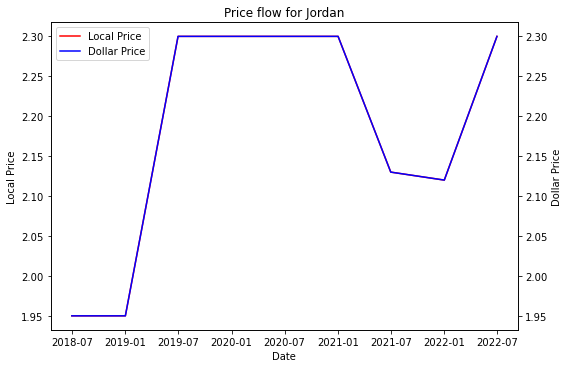

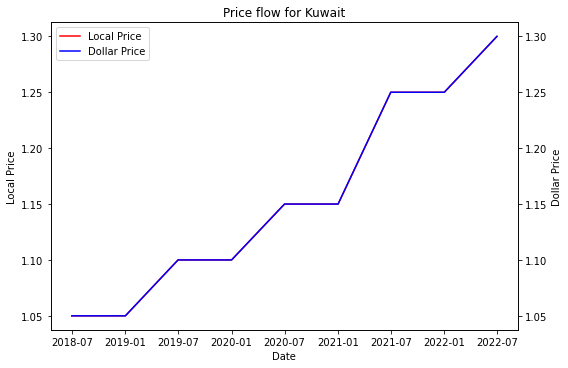

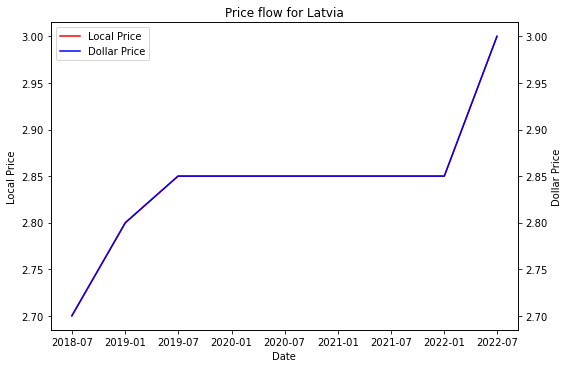

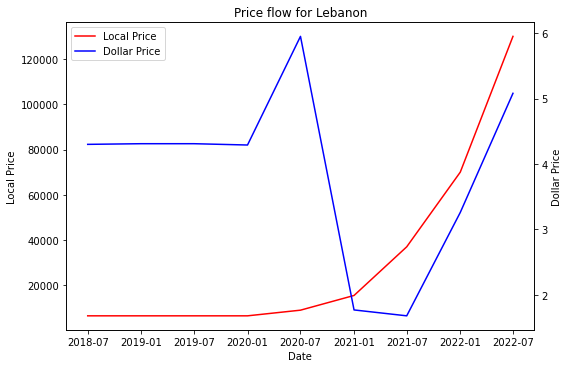

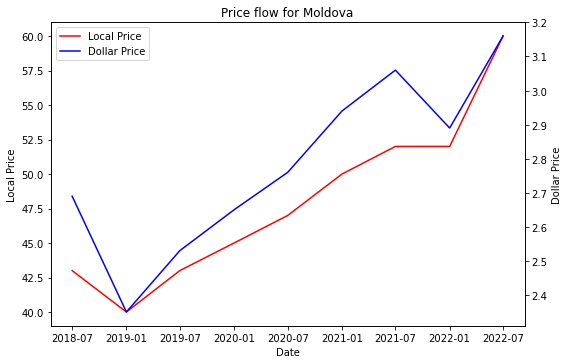

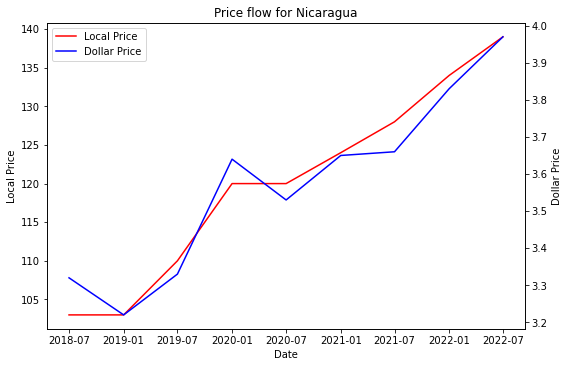

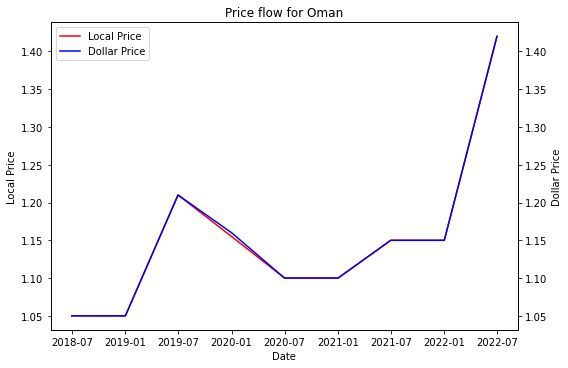

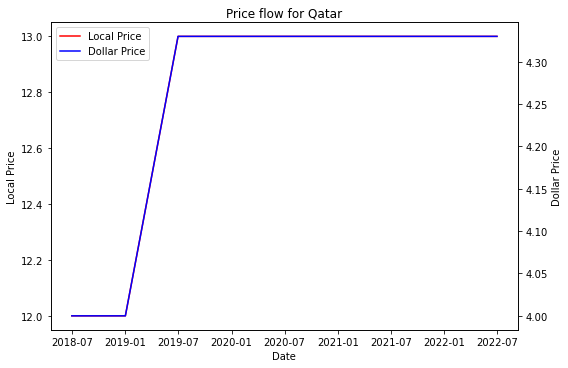

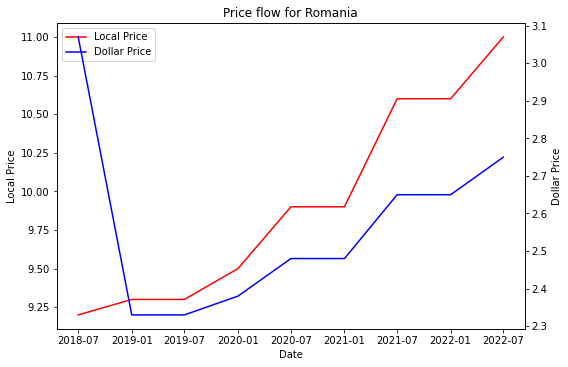

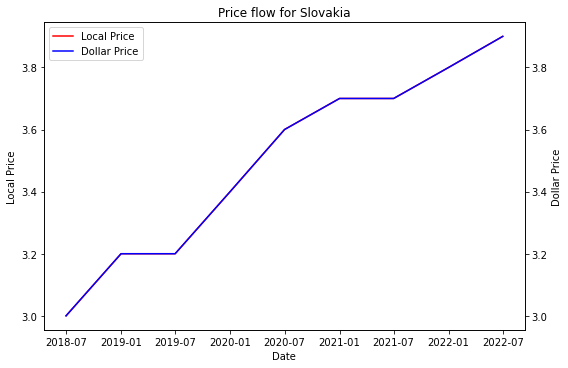

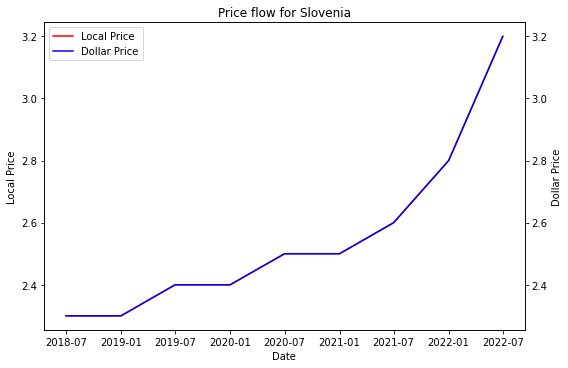

In [56]:
for c in df.country.unique():
    x = df.set_index('date')
    x = x[x['country'] == c]

    # More versatile wrapper
    fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
    # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

    par1 = host.twinx()

    host.set_xlabel("Date")
    host.set_ylabel("Local Price")
    par1.set_ylabel("Dollar Price")


    p1, = host.plot(x.index, x.local_price, label="Local Price", color='red')
    p2, = par1.plot(x.index, x.dollar_price, label="Dollar Price", color = 'blue')

    lns = [p1, p2]
    host.legend(handles=lns, loc='best')

    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
    plt.title(f'Price flow for {c}')
    # Best for professional typesetting, e.g. LaTeX
    plt.plot()